# refer
* https://medium.com/data-science-at-microsoft/error-analysis-for-object-detection-models-338cb6534051

In [1]:
import json
from pathlib import Path
from typing import Tuple
import pandas as pd

In [2]:
with open('./human_check/tpbank.json') as f:
    qms_annots = json.load(f)

In [3]:
error_stat = {}
comments = []
for annots in qms_annots:
    for annot in annots['annotations']:
        for label in annot['result']:
            if label['type'] == 'choices':
                for choice in label['value']['choices']:
                    if choice in error_stat:
                        error_stat[choice]+=1
                    else:
                        error_stat[choice]=1
            # if label['type'] == 'textarea':
            #     comments.extend(label['value']['text'])

In [7]:
df = pd.json_normalize(error_stat)
df.to_excel('error.xlsx')

AttributeError: 'DataFrame' object has no attribute 'to'

In [6]:
error_stat

{'detect long footer to footnote': 279,
 'incorrect groundtruth': 3,
 'detect small element in other element': 22,
 'detect logo in header to figure': 174,
 'detect redunant element': 7,
 'merge box': 6,
 'wrong detection': 20,
 'detect scanned to figure': 12,
 'split box': 2,
 'detect footnote to list-item': 5,
 'redundant box': 1}

In [22]:
errors = list(error_stat.items())
errors.sort(key=lambda x: x[1], reverse=True)
errors

[('high IoU threshold', 16),
 ('wrong detection', 2),
 ('incorrect groundtruth', 2),
 ('controversy box', 2),
 ('redundant box', 1)]

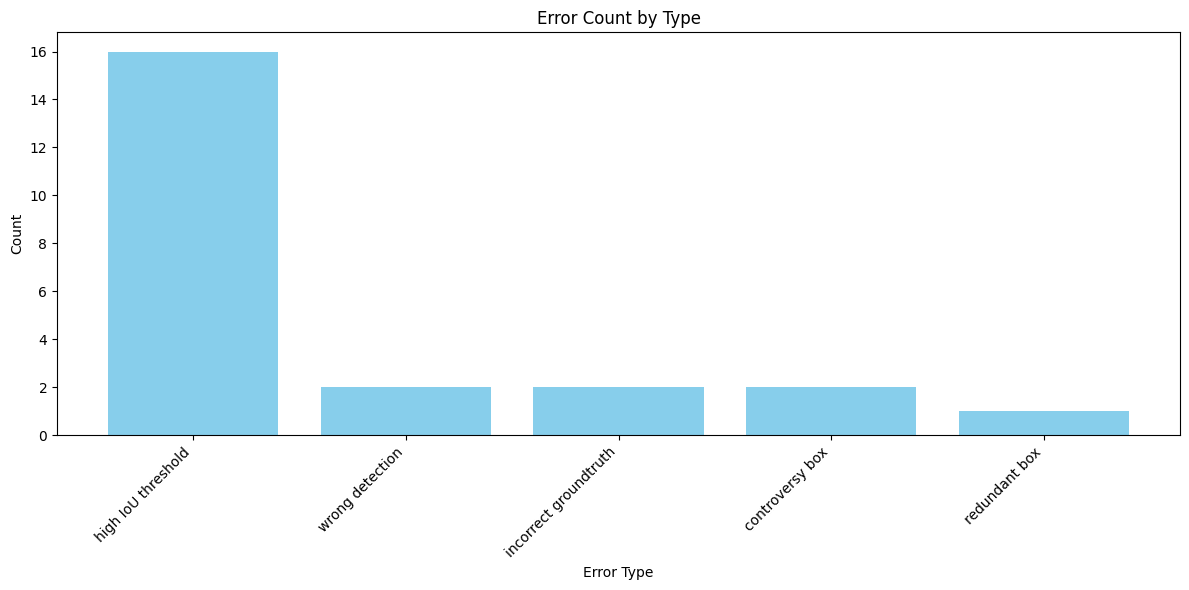

In [23]:
#
import matplotlib.pyplot as plt
import pandas as pd

# Convert data to DataFrame
df = pd.DataFrame(errors, columns=['Error Type', 'Count'])

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df['Error Type'], df['Count'], color='skyblue')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Error Count by Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

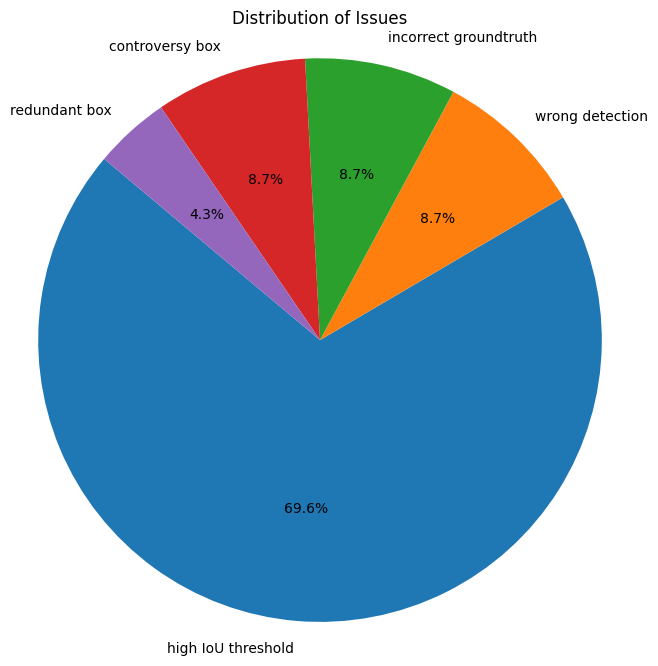

In [24]:
labels = [item[0] for item in errors]
sizes = [item[1] for item in errors]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Issues')
plt.show()

In [25]:
comments

[]

In [26]:
comments = [comment.lower() for comment in comments]

In [27]:
pip install transformers scikit-learn torch


Note: you may need to restart the kernel to use updated packages.


In [28]:
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.cluster import KMeans
import numpy as np

# Comments to cluster
stop_words = {'hơi', 'quá'}

# Function to remove stop words
def remove_stop_words(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# Load pre-trained model and tokenizer
preprocessed_comments = [remove_stop_words(comment, stop_words) for comment in comments]

model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get sentence embeddings
def get_embeddings(text_list):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

# Get embeddings for the comments
embeddings = get_embeddings(preprocessed_comments)

# Apply K-Means clustering
num_clusters = 10  # You can adjust this number based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Print the results
clustered_comments = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    clustered_comments[label].append(comments[idx])

for cluster, comments in clustered_comments.items():
    
    print(f"Cluster {cluster}:")
    for comment in comments:
        print(f"  - {comment}")


ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided []

In [ ]:
clustered_comments

{0: ['iou hơi cao',
  'iou cao',
  'iou cao',
  'iou cao',
  'iou cao',
  'iou hơi cao',
  'iou quá cao',
  'iou quá cao',
  'iou quá cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou cao',
  'iou cao',
  'iou hơi cao',
  'iou cao',
  'iou cao',
  'iou quá cao',
  'iou quá cao',
  'iou cao',
  'iou cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou hơi cao',
  'iou cao',
  'iou quá cao',
  'iou cao',
  'iou quá cao',
  'iou quá cao',
  'iou cao',
  'iou cao',
  'iou hơi cao',
  'iou cao',
  'iou cao',
  'iou hơi cao'],
 1: ['model bị miss 1 line, detect nhầm 2 list_item thành text',
  'model detect sai (gộp text và title), iou quá cao',
  'model ko detect dc table do ko có viền',
  'detect nhầm text vào table (có thể do text gióng hàng với text ở table)',
  'model detect nhầm figure trong figure, nhầm list_item thành text',
  'groundtruth "mục lục" bị duplicated',
  'groundtruth "mục lục" bị duplicated',
  'detect nhầm 1 table thành 2 table d

In [ ]:
cluster_mapping = {
    0: 'high IoU',
    1: 'fail',
    2:'textbox',
    3:'perfect',
    4:'gt incorrect',
    5:'high IoU',
    6:'classify',
    7:'classify',
    8:'thừa box',
    9:'imgs trong table',
}
data = []
for cluster in clustered_comments:
    for text in clustered_comments[cluster]:
        
        data.append({
            'text': text,
            'type':cluster_mapping[cluster]
        })
df = pd.json_normalize(data)
df.to_csv('comment.csv')

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.cluster import KMeans
import numpy as np

# Comments to cluster
stop_words = {'hơi', 'quá'}

# Function to remove stop words
def remove_stop_words(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# Load pre-trained model and tokenizer
preprocessed_comments = clustered_comments[1]

model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get sentence embeddings
def get_embeddings(text_list):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

# Get embeddings for the comments
embeddings = get_embeddings(preprocessed_comments)

# Apply K-Means clustering
num_clusters = 5  # You can adjust this number based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Print the results
clustered_comments1 = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    clustered_comments1[label].append(preprocessed_comments[idx])

for cluster, comments in clustered_comments1.items():
    
    print(f"Cluster {cluster}:")
    for comment in comments:
        print(f"  - {comment}")


Cluster 0:
  - model detect sai (gộp text và title), iou quá cao
  - detect nhầm text vào table (có thể do text gióng hàng với text ở table)
  - annot nhầm 2 figure thành 1 figure, nhầm "=>" là list_item
  - detect nhầm 3 box thành 1 box, do các box gần nhau và tương đồng nhau
  - model detect đúng, annot nhầm (text thành title)
  - model detect đúng, annot nhầm (để title trong table) và model detect nhầm title thành text
  - model nhầm title vào table, annot nhầm (để title trong table)
  - model detect đúng, annot nhầm (để title trong table)
  - detect nhầm text thành title (do chữ in đậm)
  - detect nhầm list_item thành text (do bắt đầu list ko có ký tự đặc biệt)
  - iou cao, detect nhầm (dù text line mới vẫn ở trong list_item)
  - detect nhầm (list_item trong table), 1 table thành 2 table
  - model detect đúng, annot nhầm (gộp 2 box lại thành 1)
  - detect đúng nma detect bbox hơi sát text (do ko có viền)
  - detect đúng nma detect bbox hơi sát text (do ko có viền)
  - mô hình bắt đ

In [ ]:
df = pd.read_csv('comment.csv')
comments = df['type'].value_counts().to_dict()

ValueError: could not convert string to float: 'i'

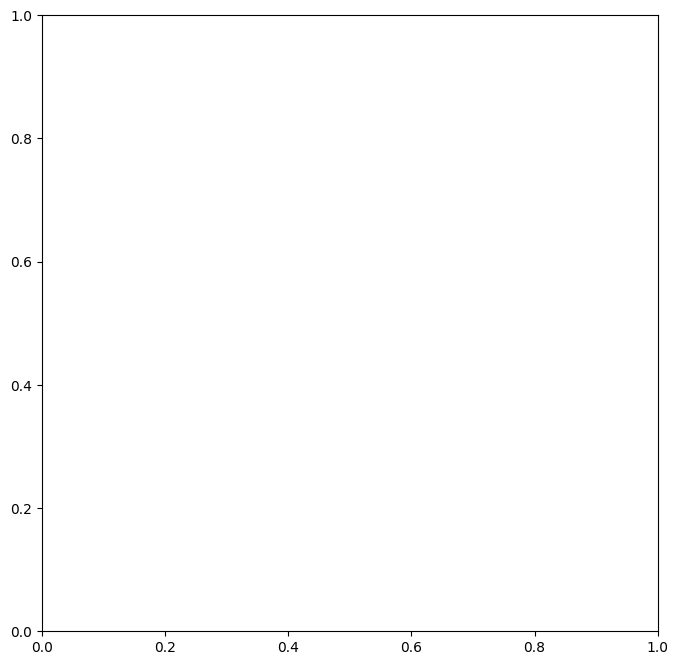

In [ ]:
labels = [item[0] for item in comments]
sizes = [item[1] for item in comments]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Comment')
plt.show()